In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import geopandas as gpd
import seaborn as sns
import spacy

from data_loader import (
    get_users_df,
    get_reviews_df,
    get_beers_df,
    get_breweries_df,
    join_breweries_on_beers,
    merge_reviews,
)

In [2]:
reviews_path_ba = "data/matched_beer_data/ratings_ba.txt"
reviews_path_rb = "data/matched_beer_data/ratings_rb.txt"
users_path_ba = "data/users_ba.csv"
users_path_rb = "data/users_rb.csv"
breweries_path = "data/matched_beer_data/breweries.csv"
beers_path = "data/matched_beer_data/beers.csv"

In [3]:
states_climate = pd.read_csv("data/states_climate.csv")
states_climate.set_index("State", inplace=True)

In [4]:
users_df_ba = get_users_df(users_path_ba)
users_df_rb = get_users_df(users_path_rb)
ba_df = get_reviews_df(reviews_path_ba)
rb_df = get_reviews_df(reviews_path_rb)
breweries_df = get_breweries_df(breweries_path)
beers_df = get_beers_df(beers_path)
beers_df = join_breweries_on_beers(beers_df, breweries_df)
reviews_df = merge_reviews(ba_df, rb_df, beers_df, users_df_ba, users_df_rb)

In [5]:
pd.set_option("display.max_columns", None)

world_ratings = reviews_df.copy()
world_ratings["nbr_ratings"] = (
    world_ratings["nbr_ratings_rb"] + world_ratings["nbr_ratings_ba"]
)
# drop rows where user_location is NaN
world_ratings = world_ratings.dropna()

# create df with only users from the us
us_users_ratings = world_ratings[
    world_ratings["user_location"].str.contains("United States")
]

# convert ratings from string to float
columns_compare = ["aroma", "appearance", "palate", "taste", "overall", "rating"]
us_users_ratings[columns_compare] = us_users_ratings[columns_compare].astype(float)

us_users_ratings["user_location"] = [
    name.replace("United States, ", "") for name in us_users_ratings["user_location"]
]

# add climate column where climate is the climate of the state the user is from
us_users_ratings["climate"] = us_users_ratings["user_location"].map(
    states_climate["Climate"]
)

C:\Users\Admin\AppData\Local\Temp\ipykernel_21244\1189097085.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  us_users_ratings[columns_compare] = us_users_ratings[columns_compare].astype(float)
C:\Users\Admin\AppData\Local\Temp\ipykernel_21244\1189097085.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  us_users_ratings["user_location"] = [
C:\Users\Admin\AppData\Local\Temp\ipykernel_21244\1189097085.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Tr

In [6]:
mean_reviews = us_users_ratings.groupby("beer_name")["overall"].aggregate(
    ["mean", "count"]
)

# Mean rating as a function of number of reviews

(array([1.9759e+04, 8.9000e+01, 2.7000e+01, 8.0000e+00, 5.0000e+00,
        4.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([1.0000e+00, 2.5310e+02, 5.0520e+02, 7.5730e+02, 1.0094e+03,
        1.2615e+03, 1.5136e+03, 1.7657e+03, 2.0178e+03, 2.2699e+03,
        2.5220e+03]),
 <BarContainer object of 10 artists>)

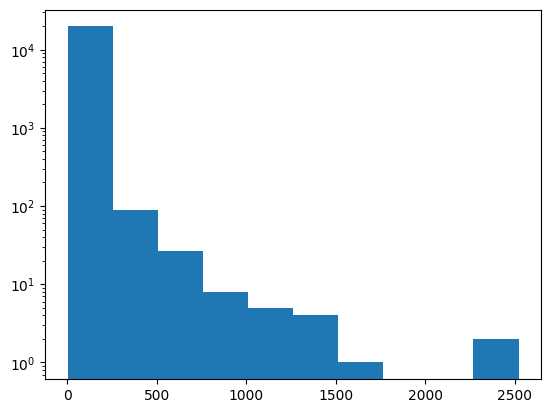

In [7]:
plt.hist(mean_reviews["count"], bins=10, log=True)

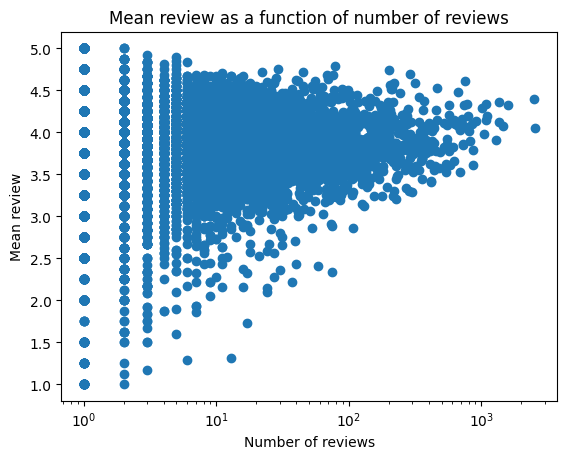

In [8]:
# plot mean review as a function of count with x- axis in log scale
plt.scatter(mean_reviews["count"], mean_reviews["mean"])
plt.xscale("log")
plt.xlabel("Number of reviews")
plt.ylabel("Mean review")
plt.title("Mean review as a function of number of reviews")
plt.show()

In [9]:
# select 5 most popular beers:
most_popular = mean_reviews.sort_values("count", ascending=False).head(5)
most_popular

,mean,count
beer_name,,
Brooklyn Black Chocolate Stout,4.055809,2522
Trappistes Rochefort 10,4.391764,2483
AleSmith Speedway Stout,4.327619,1575
Delirium Tremens,4.069993,1443
Blind Pig IPA,4.364850,1367


In [10]:
reviews_top_5 = us_users_ratings[us_users_ratings["beer_name"].isin(most_popular.index)]

In [11]:
# mean overall rating for each beer of the top 5 and each climate zone:
mean_top_5 = reviews_top_5.groupby(["beer_name", "climate"])["overall"].mean()
mean_top_5 = mean_top_5.reset_index()
mean_top_5 = mean_top_5.pivot(index="beer_name", columns="climate")
mean_top_5.columns = mean_top_5.columns.droplevel()
mean_top_5 = mean_top_5.reset_index()
# set beer_name as index and remove current index
mean_top_5 = mean_top_5.set_index("beer_name")
mean_top_5

climate,Bsk,Cfa,Cfb,Csa,Csb,Dfa,Dfb,Dfc,Dsb,Dsc
beer_name,,,,,,,,,,
AleSmith Speedway Stout,4.650000,4.342708,4.312500,4.346507,4.424242,4.309117,4.305205,4.398810,4.162037,4.083333
Blind Pig IPA,4.500000,4.385965,4.642857,4.387175,4.244792,4.396552,4.339000,4.220339,4.264706,4.250000
Brooklyn Black Chocolate Stout,4.052632,4.056685,3.961538,4.087248,4.115385,4.028530,4.069915,4.010638,4.088235,4.166667
Delirium Tremens,4.044118,4.080150,3.928571,4.041667,4.109375,4.084661,4.050664,4.070652,4.089286,4.150000
Trappistes Rochefort 10,4.410000,4.424543,4.625000,4.359879,4.250000,4.335644,4.401590,4.378571,4.413690,4.437500


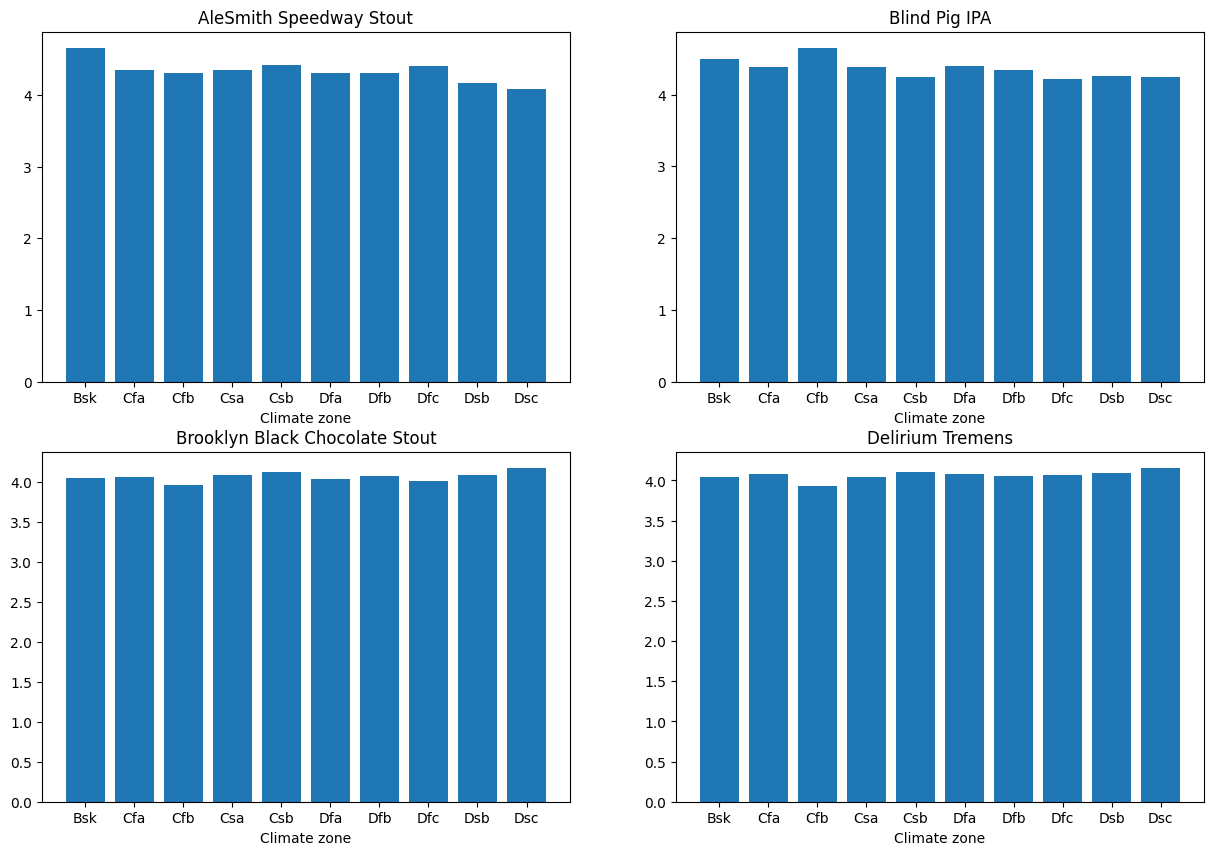

In [12]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

for i in range(4):
    row = i // 2
    col = i % 2

    axs[row, col].bar(mean_top_5.columns, mean_top_5.iloc[i])
    axs[row, col].set_title(mean_top_5.index[i])
    axs[row, col].set_xlabel("Climate zone")

plt.show()

In [13]:
from scipy import stats

for beer_name in reviews_top_5.beer_name.unique():
    reviews = reviews_top_5[reviews_top_5["beer_name"] == beer_name][
        ["beer_name", "climate", "overall"]
    ]

    # do anova test to compare mean overall rating for first beer of the top 5 and each climate zone:
    res = stats.f_oneway(
        *[
            reviews[reviews.climate == zone].overall
            for zone in reviews.climate.unique()
        ],
        axis=0
    )
    print(beer_name, res[1])

Blind Pig IPA 0.019350793873213666
AleSmith Speedway Stout 0.012981860179520379
Brooklyn Black Chocolate Stout 0.9297885125830303
Trappistes Rochefort 10 0.03441094802079153
Delirium Tremens 0.9948079578705886


# Intrayear evolution of the mean ratings

C:\Users\Admin\AppData\Local\Temp\ipykernel_21244\1448270512.py:2: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  us_users_ratings["date"] = pd.to_datetime(us_users_ratings["date"], unit="s")
C:\Users\Admin\AppData\Local\Temp\ipykernel_21244\1448270512.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  us_users_ratings["date"] = pd.to_datetime(us_users_ratings["date"], unit="s")
C:\Users\Admin\AppData\Local\Temp\ipykernel_21244\1448270512.py:3: SettingWithCopyWarning: 
A value is trying to be s

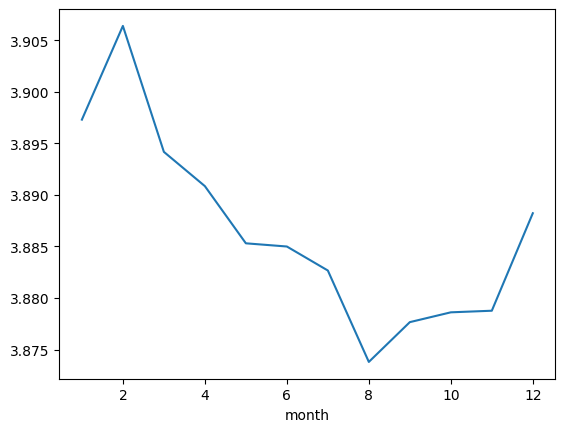

In [14]:
# evolution of the average reviews over time: convert date in unix to datetime
us_users_ratings["date"] = pd.to_datetime(us_users_ratings["date"], unit="s")
us_users_ratings["year"] = us_users_ratings["date"].dt.year
us_users_ratings["month"] = us_users_ratings["date"].dt.month
# plot average review over time but keep only month that have enough reviews
us_users_ratings.groupby("month")["overall"].mean().plot()
plt.show()

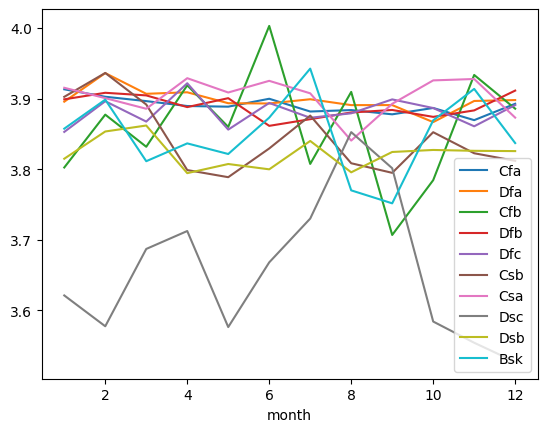

In [16]:
# # evolution of the average reviews over time: convert date in unix to datetime
# us_users_ratings["date"] = pd.to_datetime(us_users_ratings["date"], unit="s")
# us_users_ratings["year"] = us_users_ratings["date"].dt.year
# us_users_ratings["month"] = us_users_ratings["date"].dt.month
# #plot average review over time but keep only month that have enough reviews
# us_users_ratings.groupby("month")["overall"].mean().plot()
# plt.show()

# repeat the above for each climate zone
for zone in us_users_ratings["climate"].unique():
    us_users_ratings[us_users_ratings["climate"] == zone].groupby("month")[
        "overall"
    ].mean().plot(label=zone)
plt.legend()